# Problema:  Prever se um cliente vai cancelar sua assinatura

In [2]:
#!pip install pandas
#!pip install numpy
#!pip install matplotlib
#!pip install seaborn
#!pip install scikit-learn
#!pip install jupyter
#!pip install shap
#!pip install torchmetrics

In [3]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [4]:
X_train = pd.read_csv("../data/train/X_train.csv")
X_test = pd.read_csv("../data/train/X_test.csv")

y_train = pd.read_csv("../data/train/y_train.csv")
y_test = pd.read_csv("../data/train/y_test.csv")

In [5]:
X_train.shape

(2666, 15)

In [6]:
X_train.columns

Index(['Tempo_conta', 'Plano_internacional', 'Plano_correio',
       'Total_minutos_diurnos', 'Total_chamadas_diurnas',
       'Total_minutos_vespertinos', 'Total_chamadas_vespertinas',
       'Total_minutos_noturnos', 'Total_chamadas_noturnas',
       'Total_minutos_internacionais', 'Total_chamadas_internacionais',
       'Chamadas_atendimento', 'Media_cancelamento_por_estado',
       'Media_cancelamento_por_codigo_area',
       'Total_chamadas_noturnas_por_minuto'],
      dtype='object')

In [7]:
# Converter X e y para torch.Tensor
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, num_labels):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(input_dim, 100)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.linear2 = nn.Linear(100, num_labels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        return x

In [9]:
model = NeuralNetwork(15,1)

In [10]:
n_epochs = 5000
learning_rate = 0.0001

In [11]:
#Para saídas binárias com sigmoide
criterion = nn.BCELoss()


In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
for epoch in range(n_epochs):
    model.train()

    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Época [{epoch+1}/100], Loss: {loss.item():.4f}')

Época [100/100], Loss: 0.5959
Época [200/100], Loss: 0.5223
Época [300/100], Loss: 0.4682
Época [400/100], Loss: 0.4296
Época [500/100], Loss: 0.4060
Época [600/100], Loss: 0.3912
Época [700/100], Loss: 0.3826
Época [800/100], Loss: 0.3743
Época [900/100], Loss: 0.3708
Época [1000/100], Loss: 0.3643
Época [1100/100], Loss: 0.3589
Época [1200/100], Loss: 0.3528
Época [1300/100], Loss: 0.3477
Época [1400/100], Loss: 0.3414
Época [1500/100], Loss: 0.3378
Época [1600/100], Loss: 0.3322
Época [1700/100], Loss: 0.3283
Época [1800/100], Loss: 0.3225
Época [1900/100], Loss: 0.3176
Época [2000/100], Loss: 0.3135
Época [2100/100], Loss: 0.3102
Época [2200/100], Loss: 0.3056
Época [2300/100], Loss: 0.3035
Época [2400/100], Loss: 0.2996
Época [2500/100], Loss: 0.2966
Época [2600/100], Loss: 0.2927
Época [2700/100], Loss: 0.2898
Época [2800/100], Loss: 0.2877
Época [2900/100], Loss: 0.2826
Época [3000/100], Loss: 0.2810
Época [3100/100], Loss: 0.2771
Época [3200/100], Loss: 0.2753
Época [3300/100],

In [14]:
model.eval()

NeuralNetwork(
  (linear1): Linear(in_features=15, out_features=100, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [15]:
# Definindo o objeto para calcular a acurácia para uma tarefa binária
accuracy = torchmetrics.Accuracy(task="binary")
precision = torchmetrics.Precision(task="binary")
recall = torchmetrics.Recall(task="binary")
f1 = torchmetrics.F1Score(task="binary")

In [16]:
# Predições no conjunto de treino
train_pred = model(X_train_tensor)
train_pred = (train_pred >= 0.5).int() # Converte probabilidades para 0 ou 1 tem uma sigmoid na última camada

# Calcular a acurácia no conjunto de treino
train_accuracy = accuracy(train_pred, y_train_tensor.int())
train_precision = precision(train_pred, y_train_tensor.int())
train_recall = recall(train_pred, y_train_tensor.int())
train_f1 = f1(train_pred, y_train_tensor.int())

In [17]:
# Predições no conjunto de teste
test_pred = model(X_test_tensor)
test_pred = (test_pred >= 0.5).int() # Converte probabilidades para 0 ou 1 tem uma sigmoid na última camada

# Calcular a acurácia no conjunto de teste
test_accuracy = accuracy(test_pred, y_test_tensor.int())
test_precision = precision(test_pred, y_test_tensor.int())
test_recall = recall(test_pred, y_test_tensor.int())
test_f1 = f1(test_pred, y_test_tensor.int())

In [18]:
print("Acurácia no conjunto de treino:", train_accuracy.item())
print("Precisão no conjunto de treino:", train_precision.item())
print("Recall no conjunto de treino:", train_recall.item())
print("F1-score no conjunto de treino:", train_f1.item())

print("\nAcurácia no conjunto de teste:", test_accuracy.item())
print("Precisão no conjunto de teste:", test_precision.item())
print("Recall no conjunto de teste:", test_recall.item())
print("F1-score no conjunto de teste:", test_f1.item())

Acurácia no conjunto de treino: 0.9227306842803955
Precisão no conjunto de treino: 0.8947368264198303
Recall no conjunto de treino: 0.5284973978996277
F1-score no conjunto de treino: 0.6644951105117798

Acurácia no conjunto de teste: 0.9115442037582397
Precisão no conjunto de teste: 0.8799999952316284
Recall no conjunto de teste: 0.4536082446575165
F1-score no conjunto de teste: 0.5986394286155701


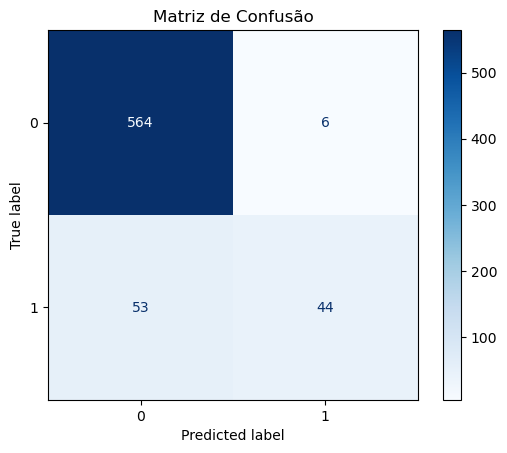

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_tensor.int().numpy(), test_pred.numpy())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão")
plt.show()

In [20]:
X_train_tensor

tensor([[ 0.0943,  0.0000,  1.0000,  ...,  0.1525,  0.1482,  0.0450],
        [-0.1321,  0.0000,  0.0000,  ...,  0.1607,  0.1361,  0.0450],
        [-0.5660,  0.0000,  1.0000,  ...,  0.1224,  0.1468,  0.0450],
        ...,
        [ 0.0755,  0.0000,  0.0000,  ...,  0.0690,  0.1482,  0.0450],
        [-0.5849,  0.0000,  0.0000,  ...,  0.1852,  0.1361,  0.0450],
        [-0.3962,  0.0000,  0.0000,  ...,  0.0667,  0.1361,  0.0450]])

In [21]:
# Salvar os pesos
torch.save(model.state_dict(), "../models/modelo_redes_neurais.pt")
